# Running Spectral Fitting

Fitting spectral methods on simulated power spectra.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats.mstats import normaltest

from fooof.sim import gen_power_spectrum, gen_group_power_spectra

In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.fit import *
from apm.fake import SimFits, print_res
from apm.plts import plot_psds, plot_psds_two
from apm.plts.utils import color_red_or_green

from apm.core.db import APMDB
from apm.core.io import save_pickle, load_pickle

from apm.sim.peaks import *

### Editorial Note

ToDo: remove old code.

In [3]:
# # # OLD:
# from apm.sim.peaks import _check_duplicate
# CEN_FREQS = np.load('/Users/tom/Code/Projects/APMethods/AperiodicMethods/apm/sim/data/freqs.npy')
# PROBS = np.load('/Users/tom/Code/Projects/APMethods/AperiodicMethods/apm/sim/data/probs.npy')

# def gen_osc_def(n_oscs=None):
#     """Generate a plausible oscillation distribution for a synthetic PSD.
#     Parameters
#     ----------
#     n_oscs : int, optional
#         Number of oscillations to generate. If None, picked at random. Default: None.
#     Returns
#     -------
#     oscs : list of list of [float, float, float], or []
#         Oscillation definitions.
#     """

#     #
#     if n_oscs is None:
#         n_oscs = np.random.choice([0, 1, 2], p=[1/3, 1/3, 1/3])

#     # Initialize list of oscillation definitions
#     oscs = []

#     # Define the power and bandwidth possibilities and probabilities
#     #pow_opts = [0.05, 0.10, 0.15, 0.20]
#     pow_opts = [0.15, 0.25, 0.5, 1.0]
#     pow_probs = [0.25, 0.25, 0.25, 0.25]
#     bw_opts = [1, 1.5, 2]
#     bw_probs = [1/3, 1/3, 1/3]

#     # Generate oscillation definitions
#     for osc in range(n_oscs):

#         cur_cen = np.random.choice(CEN_FREQS, p=PROBS)

#         while _check_duplicate(cur_cen, [it[0] for it in oscs]):
#             cur_cen = np.random.choice(CEN_FREQS, p=PROBS)

#         cur_amp = np.random.choice(pow_opts, p=pow_probs)
#         cur_bw = np.random.choice(bw_opts, p=bw_probs)

#         oscs.append([cur_cen, cur_amp, cur_bw])

#     return oscs

### Setup & Settings

In [4]:
# Notebook Settings
SAVE_FIG = False
SAVE_DATA = True

In [5]:
# Set up project database object
db = APMDB()

In [6]:
# General simulation settings
f_range = [3, 40]

off_val = 0

noise = 0.0

## Check out PSD generation and test fitting

In [7]:
# Generate a single simulated test power spectrum
exp_val = 1
peak_gen = gen_peak_def()
peaks = next(peak_gen)

In [8]:
# # Old version
# freqs, psd = sim_psd(f_range, exp_val, peaks, noise)
# # Plot and check a simulated spectrum, plotted in semi-log and log space
# plot_psds_two(freqs, psd, np.log10(freqs), np.log10(psd))

In [9]:
# Simulate an example power spectrum
freqs, psd = gen_power_spectrum(f_range, [off_val, exp_val], peaks, noise)

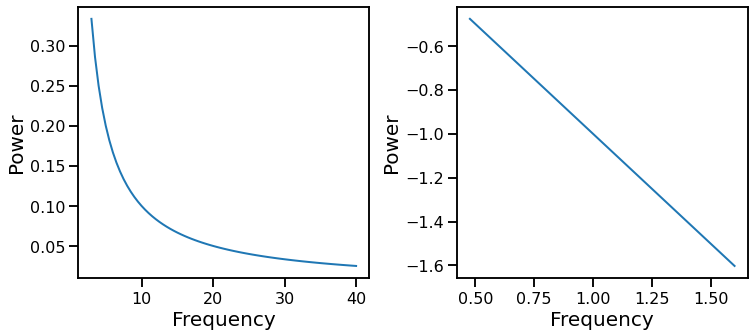

In [10]:
# Plot and check a simulated spectrum, plotted in semi-log and log space
plot_psds_two(freqs, psd, np.log10(freqs), np.log10(psd))

In [11]:
# Test out fits
print('True exponent value is ', str(exp_val), '\n')
print('OLS fit: \t', fit_ols(freqs, psd))
print('RLM fit: \t', fit_rlm(freqs, psd))
print('RLM-EA fit: \t', fit_rlm_alph(freqs, psd))
print('RLM-EO fit: \t', fit_rlm_oscs(freqs, psd))
print('RAN fit: \t', fit_ransac(freqs, psd))
print('RAN-EA fit: \t', fit_ransac_alph(freqs, psd))
print('RAN-EO fit: \t', fit_ransac_oscs(freqs, psd))
print('EXP fit: \t', fit_exp(freqs, psd))
print('EXP-EA fit: \t', fit_exp_alph(freqs, psd))
print('EXP-EO fit: \t', fit_exp_oscs(freqs, psd))
print('FOOOF fit: \t', fit_fooof(freqs, psd))

True exponent value is  1 

OLS fit: 	 -0.9999999999999998
RLM fit: 	 -0.9999999999999998
RLM-EA fit: 	 -1.0000000000000002
RLM-EO fit: 	 -0.9999999999999998
RAN fit: 	 -0.9999999999999999
RAN-EA fit: 	 -1.0
RAN-EO fit: 	 -0.9999999999999999
EXP fit: 	 -0.9999999999983533
EXP-EA fit: 	 -0.9999999999984178
EXP-EO fit: 	 -0.9999999999983533
FOOOF fit: 	 -1.0000000016880128


/Users/tom/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


## Run a Fits on Simulated Power Spectra

In [12]:
# Settings
n_psds = 150
f_range = [3, 40]
exp_val = 1
noise = 0.05

In [13]:
# # OLD: Simulate a group of PSDs
# freqs, psds = sim_n_psds(n_psds, f_range, exp_val, gen_osc_def, noise)

In [14]:
# NEW VERSION.
freqs, psds, sim_params = gen_group_power_spectra(\
    n_psds, f_range, [off_val, exp_val], gen_peak_def(), noise, return_params=True)

# TEMP:
psds = psds.T

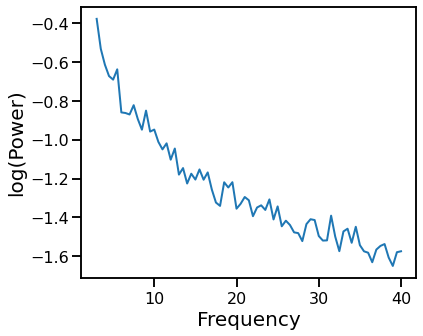

In [15]:
# Plot example simulated power spectrum from the group
plot_psds(freqs, psds[:, 10])

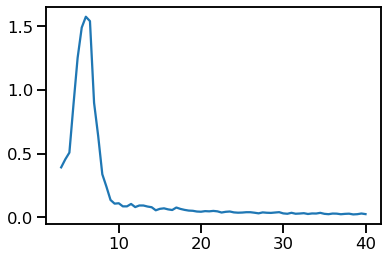

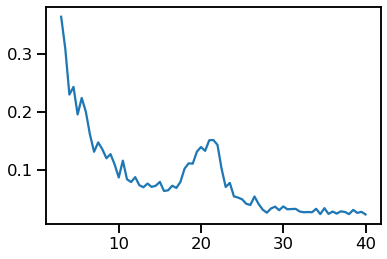

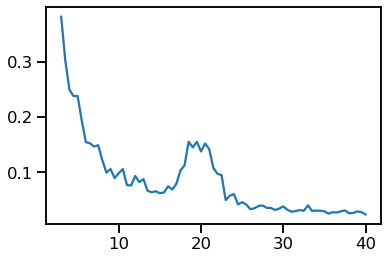

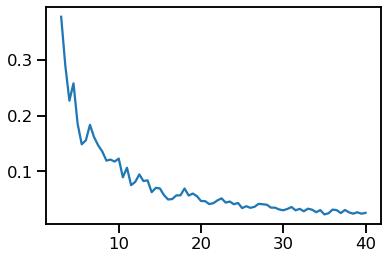

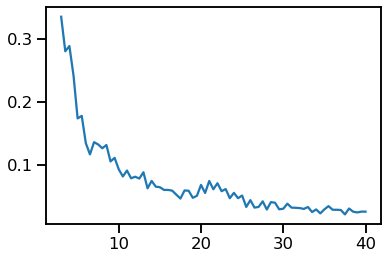

In [16]:
# Check out some of the simulated power spectra
for ind, psd in enumerate(psds.T):
    if ind < 5:
        plt.figure()
        plt.plot(freqs, psd)

In [17]:
# Initialize and set up for simulated data testing
sims = SimFits()
sims.get_fit_funcs()

In [18]:
# Check the fitting functions being used
print(list(sims.fit_funcs.keys()))

['OLS', 'OLS-EA', 'OLS-EO', 'RLM', 'RLM-EA', 'RLM-EO', 'RAN', 'RAN-EA', 'RAN-EO', 'EXP', 'EXP-EA', 'EXP-EO', 'FOOOF']


In [19]:
# Fit spectra: this fits all methods
sims.fit_spectra(exp_val, freqs, psds)

In [20]:
# Calculate metrics
avgs = sims.calc_avg_errs()
perc_good = sims.calc_perc_good()

In [21]:
# Check errors per fitting method
print('AVERAGE FIT ERRORS')
print_res(avgs)

AVERAGE FIT ERRORS
   RLM-EO   		 0.02039
   EXP-EO   		 0.02146
   OLS-EO   		 0.02146
   FOOOF    		 0.02248
   RLM-EA   		 0.02365
   RAN      		 0.02558
   RAN-EO   		 0.02740
   RAN-EA   		 0.02799
   EXP-EA   		 0.02947
   OLS-EA   		 0.02947
   RLM      		 0.02980
   OLS      		 0.03632
   EXP      		 0.03632


In [22]:
# Check errors per fitting method
print('PERCENTAGE FITS BELOW ERROR THRESHOLD')
print_res(perc_good)

PERCENTAGE FITS BELOW ERROR THRESHOLD
   RLM-EO   		 0.56667
   FOOOF    		 0.54000
   OLS-EO   		 0.53333
   EXP-EO   		 0.53333
   RLM-EA   		 0.52000
   RAN      		 0.49333
   RAN-EO   		 0.46667
   RLM      		 0.45333
   RAN-EA   		 0.45333
   OLS-EA   		 0.41333
   EXP-EA   		 0.41333
   OLS      		 0.40000
   EXP      		 0.40000


In [23]:
# Create a dataframe of the simulation errors
df = pd.DataFrame(sims.errs)

In [24]:
# Check the correlation structure between fit errors
df.corr()

,OLS,OLS-EA,OLS-EO,RLM,RLM-EA,RLM-EO,RAN,RAN-EA,RAN-EO,EXP,EXP-EA,EXP-EO,FOOOF
OLS,1.000000,0.696889,0.494258,0.917836,0.637400,0.482856,0.491941,0.013524,0.488941,1.000000,0.696889,0.494258,0.550481
OLS-EA,0.696889,1.000000,0.752193,0.729026,0.931343,0.745965,0.393000,0.070218,0.738549,0.696889,1.000000,0.752193,0.803597
OLS-EO,0.494258,0.752193,1.000000,0.594439,0.885778,0.997934,0.102500,0.009433,0.962561,0.494258,0.752193,1.000000,0.968858
RLM,0.917836,0.729026,0.594439,1.000000,0.728314,0.587572,0.639878,0.073954,0.594083,0.917836,0.729026,0.594439,0.650423
RLM-EA,0.637400,0.931343,0.885778,0.728314,1.000000,0.882972,0.365440,0.070883,0.874945,0.637400,0.931343,0.885778,0.915900
RLM-EO,0.482856,0.745965,0.997934,0.587572,0.882972,1.000000,0.098733,0.011373,0.961486,0.482856,0.745965,0.997934,0.962869
RAN,0.491941,0.393000,0.102500,0.639878,0.365440,0.098733,1.000000,0.181494,0.147269,0.491941,0.393000,0.102500,0.195351
RAN-EA,0.013524,0.070218,0.009433,0.073954,0.070883,0.011373,0.181494,1.000000,0.056959,0.013524,0.070218,0.009433,0.018800
RAN-EO,0.488941,0.738549,0.962561,0.594083,0.874945,0.961486,0.147269,0.056959,1.000000,0.488941,0.738549,0.962561,0.941707
EXP,1.000000,0.696889,0.494258,0.917836,0.637400,0.482856,0.491941,0.013524,0.488941,1.000000,0.696889,0.494258,0.550481


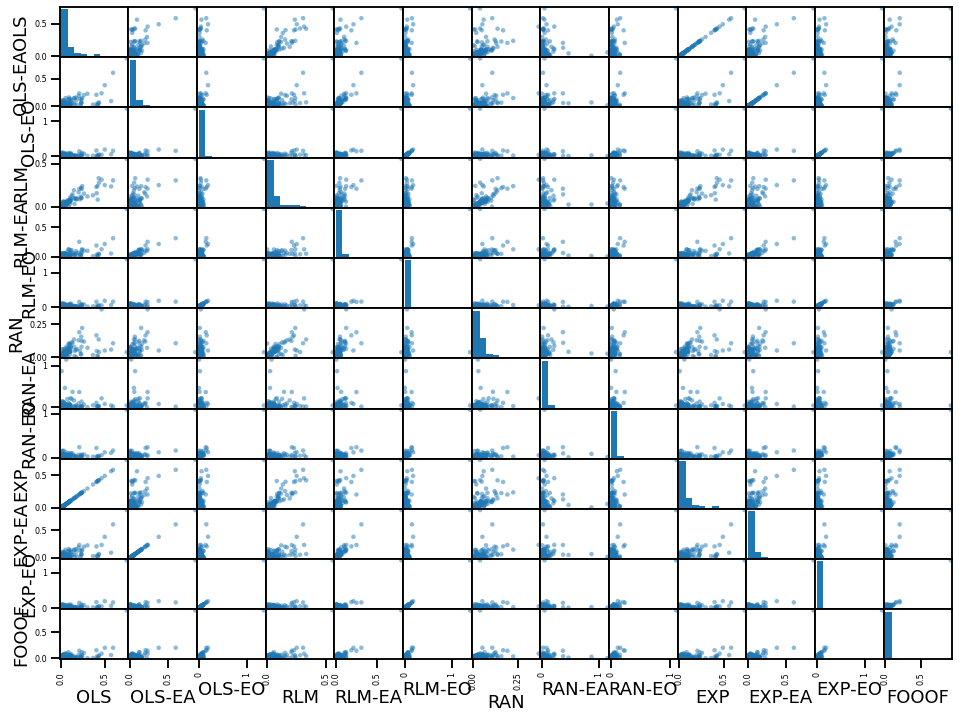

In [25]:
# Plot data distributions and inter-relations
pd.plotting.scatter_matrix(df, figsize=[16, 12]);

In [26]:
# Apply a normal test across fit-error distributions
normalities = df.apply(normaltest)

# Check which results of normal test
nt_df = pd.DataFrame([data[1] for data in normalities.values], index=normalities.index)
nt_df.style.applymap(color_red_or_green)

,0
OLS,0.000000
OLS-EA,0.000000
OLS-EO,0.000000
RLM,0.000000
RLM-EA,0.000000
RLM-EO,0.000000
RAN,0.000000
RAN-EA,0.000000
RAN-EO,0.000000
EXP,0.000000


In [27]:
# Save out simulated fit data to pickle
if SAVE_DATA:
    save_pickle(sims.errs, 'SimFits_test.p', db.sims_path)

In [28]:
# Check available simulated fit results files
sim_files = db.check_files('sims')
f_ind = sim_files.index('SimFits_test.p')

In [29]:
# Load simulated fit results data from pickle file
data = load_pickle(sim_files[f_ind], db.sims_path)
sim_dat = SimFits()
sim_dat.errs = data